## Deeper analysis of beta-lactamase (BLAC) scrape & seq data by looking at variant clusters, observed vs predicted activity under additivity, and distance of designs to evotuning set sequences.

Figs 2c, 2d, and 2e.

In [1]:
!pip install scipy==1.4.1

DEPRECATION: Python 3.5 reached the end of its life on September 13th, 2020. Please upgrade your Python as Python 3.5 is no longer maintained. pip 21.0 will drop support for Python 3.5 in January 2021. pip 21.0 will remove support for this functionality.


In [2]:
import os
import sys
import pickle
from functools import reduce
from math import log10, floor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy

from sklearn.cluster import AgglomerativeClustering

sys.path.append('../common')
import data_io_utils
import paths
import constants
import utils
import plot_style_utils

sys.path.append('../A006_simulated_annealing/')
import A006_common
from unirep import babbler1900 as babbler

sys.path.append('../A003_policy_optimization/')
import A003_common

sys.path.append('../A008_analyze_chip_1/')
import A008_common

import A010_common

%reload_ext autoreload
%autoreload 2

In [3]:
MAKE_HEATMAP_WITH_ET_UNIREP_GOF_VARIANTS_ONLY = True 

In [4]:
# Generated in mlpe-gfp-pilot repository
lfe_data_file = os.path.join(data_io_utils.S3_DATA_ROOT, 'chip_1', 
        'A052e_BLAC_log_fold_enrichment.csv')

data_io_utils.sync_s3_path_to_local(lfe_data_file, is_single_file=True)

df = pd.read_csv(lfe_data_file)

q = df['id'].apply(lambda s: pd.Series(A008_common.split_seq_id_into_features(s)))
df = df.merge(q, left_index=True, right_index=True)

display(df.head())
print(df.columns)

,lfe_250,lfe_1000,lfe_2500,lfe_5000,rep1_250,rep1_1000,rep1_2500,rep1_5000,rep2_250,rep2_1000,...,ligated_gene,ligated_gene_translated,n_mut_rel_wt,oligo_len,model,ntrain,rep,rep_hash,seq_traj_idx,special_case
0,-1.003346,-2.423684,-2.469612,-2.194874,-1.003346,-2.125728,-2.255074,-2.194874,-0.734210,-2.423684,...,ATGAGTATTCAACATTTCCGTGTCGCCCTTATTCCCTTTTTTGCGG...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,7.0,293.0,ET_Random_Init_1,96,3,33bfb65e,seq_idx_2563_2629,
1,-1.207588,-2.195691,-2.400481,-2.088745,-1.207588,-2.195691,-1.847915,-2.088745,-1.113712,-1.509455,...,ATGAGTATTCAACATTTCCGTGTCGCCCTTATTCCCTTTTTTGCGG...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,7.0,293.0,OneHot,24,2,1d0c4863,seq_idx_2053_3311,
2,-1.449553,-1.769109,-2.618223,-2.315377,-1.079944,-1.769109,-1.773516,-2.315377,-1.449553,-1.530902,...,ATGAGTATTCAACATTTCCGTGTCGCCCTTATTCCCTTTTTTGCGG...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,7.0,293.0,OneHot,96,0,2277bff5,seq_idx_2514_3406,
3,-1.268493,-2.465868,-2.812826,-2.476037,-1.027188,-2.406891,-2.536237,-2.476037,-1.268493,-2.465868,...,ATGAGTATTCAACATTTCCGTGTCGCCCTTATTCCCTTTTTTGCGG...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,7.0,293.0,OneHot,96,3,108b3ec7,seq_idx_1878_128,
4,-1.417045,-1.590053,-2.227124,-2.166924,-1.417045,-1.428771,-2.227124,-2.166924,-1.011380,-1.590053,...,ATGAGTATTCAACATTTCCGTGTCGCCCTTATTCCCTTTTTTGCGG...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,7.0,293.0,ET_Random_Init_1,96,3,33bfb65e,seq_idx_2894_1066,


Index(['lfe_250', 'lfe_1000', 'lfe_2500', 'lfe_5000', 'rep1_250', 'rep1_1000',
       'rep1_2500', 'rep1_5000', 'rep2_250', 'rep2_1000', 'rep2_2500',
       'rep2_5000', 'lib_region', 'id', 'DE_Chip_1_BLAC_NGS_01',
       'DE_Chip_1_BLAC_NGS_02', 'DE_Chip_1_BLAC_NGS_03',
       'DE_Chip_1_BLAC_NGS_04', 'DE_Chip_1_BLAC_NGS_05',
       'DE_Chip_1_BLAC_NGS_06', 'DE_Chip_1_BLAC_NGS_07',
       'DE_Chip_1_BLAC_NGS_08', 'DE_Chip_1_BLAC_NGS_09',
       'DE_Chip_1_BLAC_NGS_10', 'seq_idx', 'trajectory_idx',
       'predicted_fitness', 'ensemble_predicted_fitness', 'seq', 'protein',
       'pred_score', 'lib_aa_seq', 'constant_where_expected',
       'successfully_clones', 'error_message', 'dna_to_order', 'ligated_gene',
       'ligated_gene_translated', 'n_mut_rel_wt', 'oligo_len', 'model',
       'ntrain', 'rep', 'rep_hash', 'seq_traj_idx', 'special_case'],
      dtype='object')


In [5]:
print(df['model'].value_counts())
print()

print(df['ntrain'].value_counts())
print()

print(df['rep'].value_counts())
print()

print(df['rep_hash'].value_counts())
print()

print(df['special_case'].value_counts())
print()

ET_Random_Init_1    3254
ET_Global_Init_1    3224
OneHot              3201
Name: model, dtype: int64

96    5249
24    4430
Name: ntrain, dtype: int64

0    2560
4    1791
3    1782
2    1774
1    1772
Name: rep, dtype: int64

1f121a71    300
3d7813de    300
30cb4ce7    300
2a95c17b    300
46b57ab     300
12da09f     300
35083dba    300
4502d3      300
36079a2c    299
3764e943    299
311cbde3    298
31e54146    297
33bfb65e    297
1a4d5748    297
17cbc6c3    296
2db7371     296
3a0e3d4     295
1989c098    295
25f01ed8    295
1931926     294
f795278     294
1d0c4863    294
3e721641    293
bb13a0      293
15947f78    293
108b3ec7    292
2277bff5    292
341cf5c     291
15ce00a7    286
3ea5f6e     284
21e3a907    273
2bc1d82f    269
75e84ab     267
Name: rep_hash, dtype: int64

            8870
LargeMut     809
Name: special_case, dtype: int64



In [6]:
WT_IDX = np.argwhere(df['seq'] == constants.BETA_LAC_AA_SEQ).reshape(-1)[0]
BETA_LAC_WT_ROW = df.iloc[WT_IDX]
AB_CONCS = [250, 1000, 2500]
AB_CONC_COLS = ['lfe_' + str(s) for s in AB_CONCS]

In [7]:
plot_style_utils.set_pub_plot_context()

In [8]:
def find_non_functional_population_mean_and_std(x):
    mu = np.median(x)
    std = scipy.stats.median_absolute_deviation(x)
    
    return mu, std

def remove_completely_non_functional_variants(df):
    masks = []
    for idx in AB_CONC_COLS:
        m, s = find_non_functional_population_mean_and_std(df[idx])
        
        masks.append(df[idx] < m+2*s)
        
    mask = reduce(np.logical_and, masks)
    return df[~mask]

def relabel_clusters(clusters, sidx):
    sc = clusters[sidx]
    
    idx = 0
    d = {}
    for c in sc:
        if c not in d:
            d[c] = idx
            idx += 1

    rclust = np.zeros(len(sc))
    for k in d.keys():
        rclust[sc == k] = d[k]
        
    return rclust

def cluster_rows(M, no_plot=True, optimal_ordering=True, 
        n_clusters=5, metric='euclidean', method='ward', orientation='right', ax=None):
    
    D = scipy.spatial.distance.pdist(M, metric=metric)
    Z = scipy.cluster.hierarchy.linkage(D, method=method, metric=metric, optimal_ordering=True)
    dn = scipy.cluster.hierarchy.dendrogram(Z, no_plot=no_plot, ax=ax, 
            above_threshold_color='k', color_threshold=0, orientation=orientation)
    leaf_order = np.array(dn['leaves'])
    
    cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity=metric, linkage=method)
    cluster.fit_predict(M)
    
    rcluster_labels = relabel_clusters(cluster.labels_, leaf_order)

    return leaf_order, M[leaf_order], rcluster_labels

In [9]:
v = df['seq'].apply(A010_common.calculate_predicted_fitness_based_on_singles)
q = pd.DataFrame(v.tolist(), index=df.index, columns=['add_singles'])

df = pd.concat([df, q], axis=1)
print(df.shape)
df.head()

(9679, 47)


,lfe_250,lfe_1000,lfe_2500,lfe_5000,rep1_250,rep1_1000,rep1_2500,rep1_5000,rep2_250,rep2_1000,...,ligated_gene_translated,n_mut_rel_wt,oligo_len,model,ntrain,rep,rep_hash,seq_traj_idx,special_case,add_singles
0,-1.003346,-2.423684,-2.469612,-2.194874,-1.003346,-2.125728,-2.255074,-2.194874,-0.734210,-2.423684,...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,7.0,293.0,ET_Random_Init_1,96,3,33bfb65e,seq_idx_2563_2629,,NaN
1,-1.207588,-2.195691,-2.400481,-2.088745,-1.207588,-2.195691,-1.847915,-2.088745,-1.113712,-1.509455,...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,7.0,293.0,OneHot,24,2,1d0c4863,seq_idx_2053_3311,,NaN
2,-1.449553,-1.769109,-2.618223,-2.315377,-1.079944,-1.769109,-1.773516,-2.315377,-1.449553,-1.530902,...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,7.0,293.0,OneHot,96,0,2277bff5,seq_idx_2514_3406,,NaN
3,-1.268493,-2.465868,-2.812826,-2.476037,-1.027188,-2.406891,-2.536237,-2.476037,-1.268493,-2.465868,...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,7.0,293.0,OneHot,96,3,108b3ec7,seq_idx_1878_128,,NaN
4,-1.417045,-1.590053,-2.227124,-2.166924,-1.417045,-1.428771,-2.227124,-2.166924,-1.011380,-1.590053,...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,7.0,293.0,ET_Random_Init_1,96,3,33bfb65e,seq_idx_2894_1066,,NaN


## Compare how phenotypes compared to those predicted under additivity of singles -- this is scratch.

Main figure ready plot down below.

In [10]:
round_to_n = lambda x, n: round(x, -int(floor(log10(x))) + (n - 1))

def change_axis_to_fold_activity(ax):
    xt = ax.get_xticks()
    xtl = ['%0.2f'% x for x in 10**xt]
    ax.set_xticklabels(xtl)
    
    yt = ax.get_yticks()
    ytl = ['%0.2f'% y for y in 10**yt]
    ax.set_yticklabels(ytl)

## Examine clusters of blac activity.

- Previously we looked at functional variants, but let's look at those that are better than WT in at least one condition

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


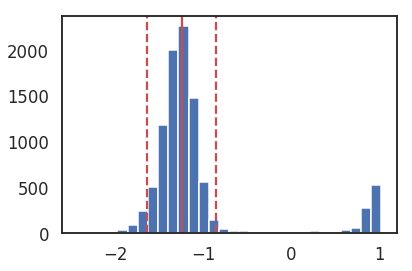

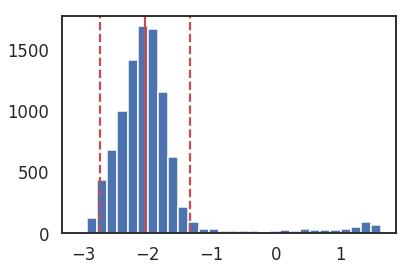

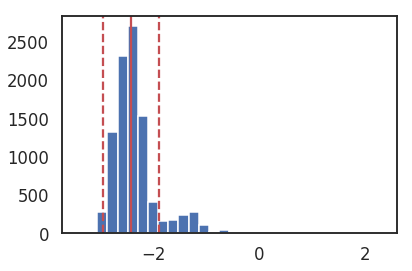

In [11]:
for idx in AB_CONC_COLS:
    plt.hist(df[idx], bins=30)
    m, s = find_non_functional_population_mean_and_std(df[idx])
    plt.axvline(m, color='r')
    plt.axvline(m-2*s, color='r', linestyle='--' )
    plt.axvline(m+2*s, color='r', linestyle='--' )
    plt.show()

In [12]:
if False:
    # Remove just non-functional variants.
    df_func = remove_completely_non_functional_variants(df)
else: 
    # Remove all variants with uniformly inferior activity relative to WT.
    masks = []
    for abc in AB_CONC_COLS:
        masks.append(df[abc] >= df[abc].iloc[WT_IDX])
    
    mask = reduce(np.logical_or, masks)
    
    df_func = df[mask]
    
if MAKE_HEATMAP_WITH_ET_UNIREP_GOF_VARIANTS_ONLY:
    df_func = df_func[df_func['model'] == 'ET_Global_Init_1']
        
WT_FUNC_IDX = np.argwhere(df_func['seq'] == constants.BETA_LAC_AA_SEQ).reshape(-1)[0]

print(WT_FUNC_IDX)

print(df.shape)
print(df_func.shape)
df_func.head()

248
(9679, 47)
(612, 47)


,lfe_250,lfe_1000,lfe_2500,lfe_5000,rep1_250,rep1_1000,rep1_2500,rep1_5000,rep2_250,rep2_1000,...,ligated_gene_translated,n_mut_rel_wt,oligo_len,model,ntrain,rep,rep_hash,seq_traj_idx,special_case,add_singles
61,0.972426,0.866153,-0.996826,-1.345216,0.977129,1.034573,-0.822826,-1.017899,0.972426,0.866153,...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,3.0,293.0,ET_Global_Init_1,96,3,12da09f,seq_idx_1977_2848,,0.871722
74,0.865278,1.374012,-1.066368,-1.192909,0.865278,1.389862,-0.784958,-0.993603,0.923488,1.374012,...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,4.0,293.0,ET_Global_Init_1,96,3,12da09f,seq_idx_250_1667,,0.997072
76,0.724719,-2.575378,-2.319491,-2.161582,0.809142,-1.764176,-2.319491,-1.958261,0.724719,-2.575378,...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,7.0,293.0,ET_Global_Init_1,96,3,12da09f,seq_idx_2956_412,,NaN
80,0.941885,-1.425134,-1.240613,-1.710308,0.995938,-1.238512,-0.722332,-1.264192,0.941885,-1.425134,...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,7.0,293.0,ET_Global_Init_1,96,3,12da09f,seq_idx_2329_2656,,0.797607
83,0.923991,1.075832,-1.213811,-1.619388,0.947960,1.213182,-0.885954,-1.146988,0.923991,1.075832,...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,7.0,293.0,ET_Global_Init_1,96,3,12da09f,seq_idx_2901_2664,,NaN


Cluster

In [13]:
REVERSE_ORDERING = True

if REVERSE_ORDERING:
    dendro_orient = 'left'
else:
    dendro_orient = 'right'

In [14]:
M = np.array(df_func[AB_CONC_COLS])
N_CLUSTERS = 4

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


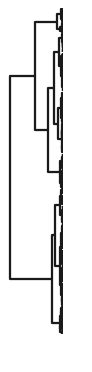

In [15]:
fig = plt.figure(figsize=(1,6))
ax = plt.gca()
sidx, Ms, clusters = cluster_rows(M, no_plot=False, ax=ax, n_clusters=N_CLUSTERS, orientation=dendro_orient)
ax.axis('off')
plt.show()

if MAKE_HEATMAP_WITH_ET_UNIREP_GOF_VARIANTS_ONLY:
    plot_style_utils.save_for_pub(fig=fig, path='figures/better_than_wt_cluster_dendrogram_ETUniRep_only')
else:
    plot_style_utils.save_for_pub(fig=fig, path='figures/better_than_wt_cluster_dendrogram')

In [16]:
if REVERSE_ORDERING:
    sidx = np.flip(sidx)
    Ms = np.flipud(Ms)
    clusters = (N_CLUSTERS - np.flip(clusters)) - 1

In [17]:
df_func_clust = df_func.iloc[sidx]

WT_FUNC_CLUST_IDX = np.argwhere(df_func_clust['seq'] == constants.BETA_LAC_AA_SEQ).reshape(-1)[0]
print(WT_FUNC_CLUST_IDX)

336


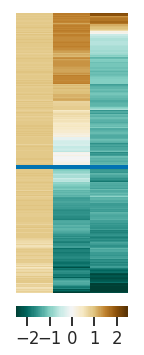

In [18]:
fig = plt.figure(figsize=(2,6))
sns.heatmap(Ms, cmap=plot_style_utils.DIV_PALETTE, 
            cbar_kws={'fraction':0.1, 'pad':0.04, 'aspect': 10, 'orientation':'horizontal'},
            vmin=-2.5, vmax=2.5)

plot_style_utils.prettify_ax(plt.gca())
plt.axhline(WT_FUNC_CLUST_IDX, color=plot_style_utils.CAT_PALETTE[0], linewidth=4)
plt.yticks([])
plt.xticks([])

plt.show()

if MAKE_HEATMAP_WITH_ET_UNIREP_GOF_VARIANTS_ONLY:
    plot_style_utils.save_for_pub(fig=fig, path='figures/better_than_wt_clustered_heatmap_ETUniRep_only')
else:
    plot_style_utils.save_for_pub(fig=fig, path='figures/better_than_wt_clustered_heatmap')

ET_Global_Init_1    1.0
Name: model, dtype: float64
0 (47, 3)


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


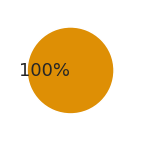

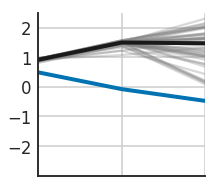

ET_Global_Init_1    1.0
Name: model, dtype: float64
1 (226, 3)


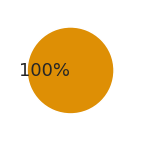

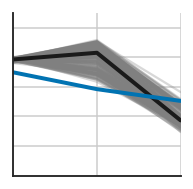

ET_Global_Init_1    1.0
Name: model, dtype: float64
2 (64, 3)


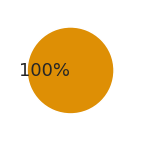

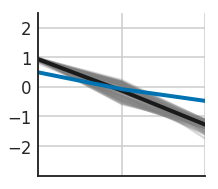

ET_Global_Init_1    1.0
Name: model, dtype: float64
3 (275, 3)


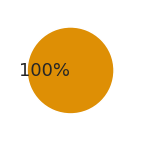

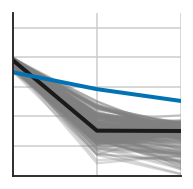

In [19]:
for cidx in range(N_CLUSTERS):
    cvars = Ms[clusters == cidx]
    sub_df = df_func_clust[clusters == cidx]
    
    props = sub_df['model'].value_counts()/np.sum(sub_df['model'].value_counts())
    print(props)
    
    # Pie chart
    fig = plt.figure(figsize=(2,2))
    patches, texts, _ = plt.pie(np.array(props), autopct='%0.0f%%', colors=plot_style_utils.CAT_PALETTE[1:])
#     for t in texts:
#         t.set_horizontalalignment('right')
#         t.set_verticalalignment('center')
    
    plot_style_utils.save_for_pub(fig=fig, path='figures/pie_chart_cluster_' + str(cidx+1))
    
    cmedian = np.median(cvars, axis=0)
    print(cidx, cvars.shape)
    
    fig = plt.figure(figsize=(3,3))
    plot_style_utils.prettify_ax(plt.gca())
    plt.plot(cvars.T, color=plot_style_utils.GRAY, alpha=0.3)
    plt.plot(cmedian, '-', color='k', linewidth=4)
    plt.plot(Ms[WT_FUNC_CLUST_IDX], '-', color=plot_style_utils.CAT_PALETTE[0], linewidth=4)
    plt.xlim([0, 2])
    plt.xticks([0,1,2])
    plt.gca().set_xticklabels([])
    plt.ylim([-3, 2.5])
    plt.yticks([-2,-1,0,1,2])
    plt.grid(True)
    
    if cidx == 1 or cidx == 3:
        plt.gca().set_yticklabels([])
    
    plt.show()
    
    if MAKE_HEATMAP_WITH_ET_UNIREP_GOF_VARIANTS_ONLY:
        plot_style_utils.save_for_pub(fig=fig, path='figures/cluster_' + str(cidx+1) + '_ETUniRep1_only')
    else:
        plot_style_utils.save_for_pub(fig=fig, path='figures/cluster_' + str(cidx+1))
    
    

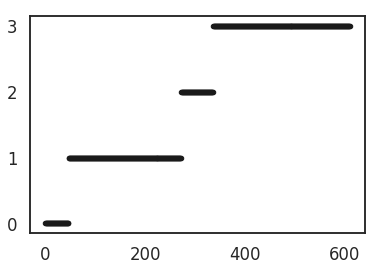

In [20]:
plt.plot(clusters, '.k')
plt.show()

## Let's look at cluster 1 sequences under additivity vs their actual phenotype.

In [21]:
print(df_func_clust.shape)
print(clusters.shape)

(612, 47)
(612,)


In [22]:
mask = np.logical_and(clusters == 1, df_func_clust['model'] == 'ET_Global_Init_1')

top_clust_df = df_func_clust[mask]
top_clust_df['n_mut_rel_wt'] = top_clust_df['n_mut_rel_wt'].astype(int)

top_clust_df['add_singles_rel_wt'] = top_clust_df['add_singles'] - A010_common.blac_edit2qfunc[None]
top_clust_df['lfe_1000_rel_wt'] = top_clust_df['lfe_1000'] - df['lfe_1000'].iloc[WT_IDX]


print(top_clust_df.shape)

(226, 49)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

In [23]:
pal = plot_style_utils.SEQ_PALETTE
pal_idx = np.round(np.linspace(0, (len(pal)-1)/1.3, np.max(top_clust_df['n_mut_rel_wt']))).astype(int)

pal_to_use = [tuple(e) for e in list(np.array(pal)[pal_idx])]

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


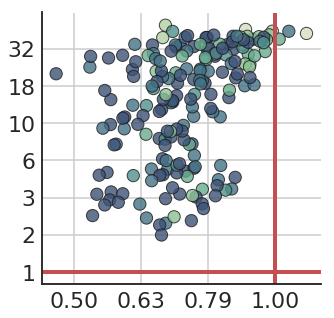

In [24]:
fig = plt.figure(figsize=(5,5))
ax = sns.scatterplot(x='add_singles_rel_wt', y='lfe_1000_rel_wt', data=top_clust_df, hue='n_mut_rel_wt',
                    legend=False, s=150, alpha=0.8, palette=pal_to_use, edgecolor='k', linewidth=1)
plot_style_utils.prettify_ax(ax)
plt.axvline(0, color='r', linewidth=4)
plt.axhline(0, color='r', linewidth=4)

# In A007b when formatting the Firnberg dataset we take 
# log10 of 'mutational' tolerance, which is an unlogged 
# measure of fitness from the paper.
# Here we represent this in linear space by transforming xlabels = 10**xticks
xticks = ax.get_xticks()
ax.set_xticklabels(['%0.2f'%x for x in 10**xticks], fontsize=22) 


# Similarly in our dataset, we're all in log-space base 10.
yticks = ax.get_yticks()
ax.set_yticklabels(['%0.0f'%x for x in 10**yticks], fontsize=22) 

ax.set_xlabel('')
ax.set_ylabel('')

plt.grid(True)
plt.show()

if MAKE_HEATMAP_WITH_ET_UNIREP_GOF_VARIANTS_ONLY:
    plot_style_utils.save_for_pub(fig=fig, path='figures/observed_vs_additive_predicted_ETUniRep_only')
    top_clust_df.to_csv('Cluster_1_ET_UniRep_BLAC_designs.csv')
else:
    plot_style_utils.save_for_pub(fig=fig, path='figures/observed_vs_additive_predicted')
    top_clust_df.to_csv('Cluster_1_BLAC_designs.csv')

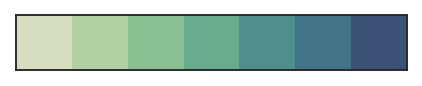

In [25]:
ax = sns.palplot(pal_to_use)
fig = plt.gca().get_figure()
plt.show()

plot_style_utils.save_for_pub(fig=fig, path='figures/observed_vs_additive_predicted_colorbar')

## Compute distances of successful UniRep designs to nearest Evotuning set member

First filter by those that are some what close to wild-type

In [26]:
with open('../A011_examine_UniRep_manifolds/BLAC_evotuning_seqs_train_betalac2.txt') as f:
    content = f.readlines()
et_seqs = [x.strip() for x in content] 

print(len(et_seqs))

62155


In [27]:
ld_wt = utils.levenshtein_distance_matrix([constants.BETA_LAC_AA_SEQ], et_seqs).reshape(-1)

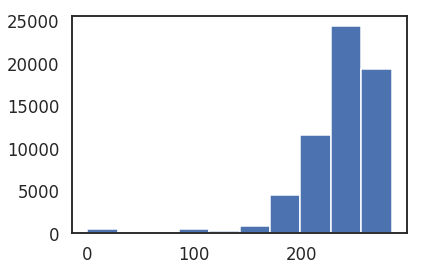

In [28]:
plt.hist(ld_wt)
plt.show()

In [29]:
et_seqs_possible_close = list(np.array(et_seqs)[ld_wt < 40])
print(len(et_seqs_possible_close))

524


In [30]:
df_super_func = df_func_clust[clusters <= 3]
print(df_super_func.shape)

(612, 47)


In [31]:
df_super_func_unirep = df_super_func[df_super_func['model'] == 'ET_Global_Init_1']
print(df_super_func_unirep.shape)

(612, 47)


In [32]:
ld_mat = utils.levenshtein_distance_matrix(list(df_super_func_unirep['seq']), et_seqs_possible_close)

In [33]:
min_dist = np.min(ld_mat, axis=1)
print(min_dist.shape)

(612,)


And to wild-type

In [34]:
ld_wt = utils.levenshtein_distance_matrix(list(df_super_func_unirep['seq']), [constants.BETA_LAC_AA_SEQ]).reshape(-1)

## Now plot

In [35]:
def dist_plot(ax, dists):
    uv, uc = np.unique(dists, return_counts=True)
    
    plot_style_utils.prettify_ax(ax)
    
    ax.bar(uv, uc, color=plot_style_utils.GRAY)
    ax.axvline(np.median(dists), color='r')
    
    ax.set_xticks([1,3,5,7])
    ax.tick_params(axis='y', which='minor', pad=1)
    ax.grid(True)

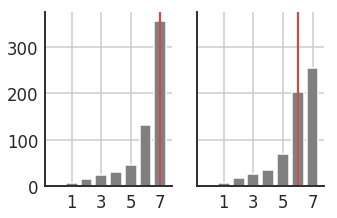

In [36]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(5,3.2))
dist_plot(ax[0], ld_wt)
dist_plot(ax[1], min_dist)
plt.show()

if MAKE_HEATMAP_WITH_ET_UNIREP_GOF_VARIANTS_ONLY:
    plot_style_utils.save_for_pub(fig=fig, path='figures/lev_distances_to_WT_and_ET_seqs_ETUniRep_only')
else:
    plot_style_utils.save_for_pub(fig=fig, path='figures/lev_distances_to_WT_and_ET_seqs')